##Import Required Libraries

In [41]:
import os, numpy as np, math, scipy, re, pandas as pd,csv
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
from nltk.corpus import stopwords, words
from nltk.util import ngrams
from numpy import hstack
from fnmatch import fnmatch
from itertools import product, combinations, zip_longest
import gensim.downloader as api
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.ticker import StrMethodFormatter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


##GloVe Model

In [2]:

glove_model = api.load("glove-twitter-200")



[==================================================] 100.0% 758.5/758.5MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


##Similarity Measure of Embeddings

In [0]:
def glove_embedding_distance(fir1 , fir2):
  try:
    return(round(model.similarity(fir1, fir2)*100,2))
  except:
    return 0



In [0]:
def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()
    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    cleaned_words = set([w for w in words if w not in stopword_set])
    return cleaned_words

In [0]:
def glv_cosine_distance_wordembedding_method(s1, s2):
  try:
    vector_1 = np.mean([glove_model[word] for word in preprocess(s1)],axis=0)
    vector_2 = np.mean([glove_model[word] for word in preprocess(s2)],axis=0)
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    #print('Word Embedding method with a cosine distance asses that our two sentences are similar to',round((1 -cosine)*100,2),'%')
    return round((1 -cosine)*100,2)
  except:
    if(preprocess(s1) == preprocess(s2)):
      return 100
    else:
      return 0

##Load Dataset

In [0]:
items = os.listdir('/content')
for file in items:
  # To fetch all .tsv files
  if fnmatch(file, '*Event*'):
    #print (file)
    event = pd.read_csv(file , header=None, sep = '\t')
  elif fnmatch(file, '*Sub*'):
    subscription = pd.read_csv(file , header=None, sep = '\t')
  elif fnmatch(file, '*Relevance*'):
    relevance_gold = pd.read_csv(file , header=None, sep = '\t')

##Preprocessing Relevance Data

In [6]:
relevance_gold_event = []
relevance_gold_sub = []
for i in relevance_gold.itertuples():
  #sub = i._2.strip("[]").split(',')
  #print([i.split() for i in sub])
  #relevance_gold_event.append([i.split() for i in sub])
  relevance_gold_event.append(i._2.strip("[]").split(','))
  relevance_gold_sub.append(i._1.strip("[]").split(','))
flat_list = [item for sublist in relevance_gold_sub for item in sublist]
print(flat_list)

['13-1', '63-1']


##Create Gold Standard Dictionary

In [7]:
zipbObj = zip(flat_list, relevance_gold_event)
 
# Create a dictionary from zip object
gold_dict = dict(zipbObj)

print(gold_dict)

{'13-1': ['132-52', ' 132-53', ' 132-50', ' 132-51', ' 132-56', ' 132-57', ' 132-54', ' 132-55', ' 132-49', ' 132-48', ' 132-47', ' 132-11', ' 132-10', ' 132-13', ' 132-12', ' 132-40', ' 132-41', ' 132-42', ' 132-43', ' 132-44', ' 132-45', ' 132-46', ' 132-37', ' 132-36', ' 132-39', ' 132-38', ' 132-8', ' 132-7', ' 132-6', ' 132-5', ' 132-9', ' 132-29', ' 132-4', ' 132-25', ' 132-3', ' 132-26', ' 132-2', ' 132-27', ' 132-1', ' 132-28', ' 132-33', ' 132-32', ' 132-35', ' 132-34', ' 132-31', ' 132-30', ' 132-60', ' 132-65', ' 132-66', ' 132-67', ' 132-18', ' 132-68', ' 132-19', ' 132-61', ' 132-16', ' 132-62', ' 132-17', ' 132-63', ' 132-14', ' 132-64', ' 132-15', ' 132-24', ' 132-23', ' 132-22', ' 132-21', ' 132-59', ' 132-20', ' 132-58'], '63-1': ['5-30', ' 5-31', ' 5-32', ' 5-37', ' 5-38', ' 5-39', ' 5-33', ' 5-34', ' 5-35', ' 5-36', ' 5-20', ' 5-21', ' 5-28', ' 5-29', ' 5-26', ' 5-27', ' 5-24', ' 5-25', ' 5-22', ' 5-23', ' 5-67', ' 5-66', ' 5-68', ' 5-19', ' 5-63', ' 5-62', ' 5-65', 

##Event Matcher

In [0]:
from collections import defaultdict
gloveDict = defaultdict(list)
#word2vecDict = {}
for i in event.itertuples():
    #print(i)
    event_types_prop_glv = []
    event_value_glv = []
    event_values = i._2.strip("{}").split(',')
    event_types_prop_glv.append([i.split('=')[0] for i in event_values])
    event_value_glv.append([i.split('=')[1] for i in event_values])
    
    for j in subscription.itertuples():
        
        subscription_types_prop_glv = []
        subscription_value_glv = []
        subscription_values = j._2.strip("{}").split(',')
        subscription_types_prop_glv.append([i.split('~')[0] for i in subscription_values])
        sec = [i.split('~')[1] for i in subscription_values]
        subscription_value_glv.append([i.split('=')[1] for i in sec])
       
        for slist in subscription_types_prop_glv:
          for elist in event_types_prop_glv:
            dist = 0
            for a, b in product(slist, elist):  
              
                cos_dist = glv_cosine_distance_wordembedding_method(a,b)
                
                if(cos_dist > 65 ):
                 
                  dist = dist + cos_dist
        #print("===============", dist)          
        if(dist > 500):
          #print("================",dist)
          for slist in subscription_value_glv:
            for elist in event_value_glv:
              final_dist = 0
              for a,b in product(slist, elist):
                #try:
                  cos_dist = glv_cosine_distance_wordembedding_method(a,b)
                  
                  if(cos_dist > 80 ):
                    
                    final_dist = final_dist + cos_dist
                  
              
          if(final_dist >= 450):
            
            gloveDict[j._1].append(i._1)

##Evaluation Metric

In [0]:

acc_each_rec = 0
prec_each_rec = 0
recall_each_rec = 0
f1_scr_each_rec = 0
  
for k in gold_dict.keys() & gloveDict.keys():
    
    a = gold_dict[k]
    b = gloveDict[k]
    count = 0
    correct = 0
    a = list(map(str.strip, a))
    b = list(map(str.strip, b))
    tp_tn = sum(el in a for el in b)
    fn = get_false_negatives(a, b)
    fp = get_false_positives(a, b)
    acc_each_rec = acc_each_rec + (tp_tn/(tp_tn + fp + fn))
    prec_each_rec = prec_each_rec + (tp_tn/ (tp_tn + fp))
    recall_each_rec = recall_each_rec + (tp_tn/ (fn + tp_tn))
    f1_scr_each_rec = (2 * prec_each_rec * recall_each_rec)/(prec_each_rec + recall_each_rec)

print("Acurracy of the system is :", acc_each_rec/len(gold_dict.keys())*100)
print("Precision of the system is :", prec_each_rec/len(gold_dict.keys())*100)
print("Recall of the system is :", recall_each_rec/len(gold_dict.keys())*100)
print("F1 Score of the system is :", f1_scr_each_rec/len(gold_dict.keys()))

In [0]:

def get_false_negatives(actual, pred):
  cnt_fn = 0
  #len(list(set(list1) ^ set(list2)))
  for i in range(len(actual)):
    if(actual[i] not in pred):
      cnt_fn += 1
  return(cnt_fn)

def get_false_positives(actual, pred):
  cnt_fp = 0
  for i in range(len(pred)):
    if(pred[i] not in actual):
      cnt_fp += 1
  return(cnt_fp)


##Visualization

In [0]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,200), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.savefig('glove_plot.png')
    plt.show()
    

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


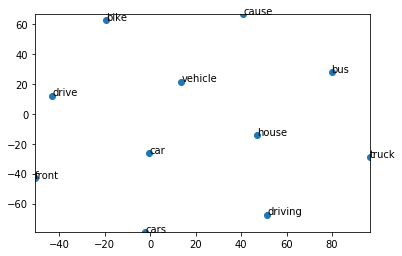

In [6]:
display_closestwords_tsnescatterplot(glove_model, 'car')